# Stress Detection in Song Lyrics Using Fine-Tuned BERT Model

## Set up

In [78]:
!pip install datasets transformers evaluate optuna openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [86]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import torch
import numpy as np
import evaluate
import optuna
import openai
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

## StressBERT Model

In [2]:
# Load the Dreaddit dataset
ds = load_dataset("asmaab/dreaddit")

print(f"\n\n{ds}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train_data.csv:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

validation_data.csv:   0%|          | 0.00/589k [00:00<?, ?B/s]

test-data.csv:   0%|          | 0.00/759k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2270 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/568 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/715 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex_liwc_cause', 'lex_liwc_discrep', 'lex_liwc_tenta

In [4]:
# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_ds = ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/2270 [00:00<?, ? examples/s]

Map:   0%|          | 0/568 [00:00<?, ? examples/s]

Map:   0%|          | 0/715 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex_liwc_cause', 'lex_liwc_discrep', 'lex_liwc_tenta

In [7]:
# Convert to PyTorch Format
tokenized_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [11]:
# Load BERT
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [230]:
# Evaluation metric - training set has good class balance so used accuracy
metric = evaluate.load("accuracy")

In [25]:
# Convert BERT output to binary prediction, apply metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [13]:
# Test train with mainly default vals
training_args = TrainingArguments(output_dir="test_trainer",
                                  eval_strategy="epoch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.734904,0.704895
2,0.406700,0.797888,0.790210
3,0.406700,1.104279,0.784615


TrainOutput(global_step=852, training_loss=0.28632435328523875, metrics={'train_runtime': 163.6617, 'train_samples_per_second': 41.61, 'train_steps_per_second': 5.206, 'total_flos': 1791786287001600.0, 'train_loss': 0.28632435328523875, 'epoch': 3.0})

In [18]:
# Gridsearch using Optuna

def objective(trial):
    # Hyperparameters trials
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
    per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [8, 16, 32])
    num_train_epochs = trial.suggest_int('num_train_epochs', 1, 5)

    # Initialize the model in each trial
    model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    # Define TrainingArguments with suggested hyperparameters
    training_args = TrainingArguments(
        output_dir="test_trainer",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir="logs",
        learning_rate=learning_rate,   # Use values from Optuna for following hyper parameters
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',  # Eval Metric
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["validation"],
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model and return accuracy
    eval_result = trainer.evaluate()
    return eval_result["eval_accuracy"]  # Optuna optimizes this value


# Create an Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=12)

print("Best hyperparameters: ", study.best_params)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-10-03 07:10:13,384] A new study created in memory with name: no-name-a6e312de-2d7c-4752-8e9d-aee26c56c358
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions an

Step,Training Loss,Validation Loss


[I 2024-10-03 07:13:48,710] Trial 0 finished with value: 0.8415492957746479 and parameters: {'learning_rate': 4.12397367509515e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5}. Best is trial 0 with value: 0.8415492957746479.
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in versi

Step,Training Loss,Validation Loss,Accuracy
500,0.561100,0.511946,0.790493


Step,Training Loss,Validation Loss,Accuracy
500,0.561100,0.511946,0.790493
1000,0.410300,0.970618,0.544014


[I 2024-10-03 07:18:06,347] Trial 1 finished with value: 0.7904929577464789 and parameters: {'learning_rate': 0.00020249680629672758, 'per_device_train_batch_size': 8, 'num_train_epochs': 5}. Best is trial 0 with value: 0.8415492957746479.
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in vers

Step,Training Loss,Validation Loss,Accuracy
500,0.583500,0.820336,0.684859
1000,0.390400,0.590490,0.786972


[I 2024-10-03 07:21:36,550] Trial 2 finished with value: 0.7869718309859155 and parameters: {'learning_rate': 0.00013578085168924886, 'per_device_train_batch_size': 8, 'num_train_epochs': 4}. Best is trial 0 with value: 0.8415492957746479.
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in vers

Step,Training Loss,Validation Loss,Accuracy
500,0.678500,0.675398,0.545775


[I 2024-10-03 07:24:13,478] Trial 3 finished with value: 0.545774647887324 and parameters: {'learning_rate': 0.00018958120598955587, 'per_device_train_batch_size': 8, 'num_train_epochs': 3}. Best is trial 0 with value: 0.8415492957746479.
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in versi

Step,Training Loss,Validation Loss


[I 2024-10-03 07:25:42,472] Trial 4 finished with value: 0.829225352112676 and parameters: {'learning_rate': 1.8439574652785088e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2}. Best is trial 0 with value: 0.8415492957746479.
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in vers

Step,Training Loss,Validation Loss,Accuracy
500,0.263800,0.640034,0.823944


[I 2024-10-03 07:28:50,435] Trial 5 finished with value: 0.823943661971831 and parameters: {'learning_rate': 2.0884709313912038e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4}. Best is trial 0 with value: 0.8415492957746479.
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in vers

Step,Training Loss,Validation Loss


[I 2024-10-03 07:32:24,705] Trial 6 finished with value: 0.8204225352112676 and parameters: {'learning_rate': 3.4902791898031984e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 5}. Best is trial 0 with value: 0.8415492957746479.
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in ver

Step,Training Loss,Validation Loss


[I 2024-10-03 07:33:59,033] Trial 7 finished with value: 0.8415492957746479 and parameters: {'learning_rate': 6.032838922649393e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}. Best is trial 0 with value: 0.8415492957746479.
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in vers

Step,Training Loss,Validation Loss


[I 2024-10-03 07:36:09,607] Trial 8 finished with value: 0.8257042253521126 and parameters: {'learning_rate': 1.4827149755562921e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 3}. Best is trial 0 with value: 0.8415492957746479.
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in ver

Step,Training Loss,Validation Loss,Accuracy
500,0.408800,0.488974,0.859155


[I 2024-10-03 07:38:46,806] Trial 9 finished with value: 0.8591549295774648 and parameters: {'learning_rate': 2.231538584128501e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3}. Best is trial 9 with value: 0.8591549295774648.
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in versi

Step,Training Loss,Validation Loss


[I 2024-10-03 07:39:41,669] Trial 10 finished with value: 0.8221830985915493 and parameters: {'learning_rate': 1.0046957979207683e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 1}. Best is trial 9 with value: 0.8591549295774648.
<ipython-input-18-9f097f8a4e35>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-4)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in ver

Step,Training Loss,Validation Loss


[I 2024-10-03 07:42:35,663] Trial 11 finished with value: 0.545774647887324 and parameters: {'learning_rate': 0.0004673116585773188, 'per_device_train_batch_size': 32, 'num_train_epochs': 4}. Best is trial 9 with value: 0.8591549295774648.


Best hyperparameters:  {'learning_rate': 2.231538584128501e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3}


In [22]:
# Train model with best hyper params from grid search

# Load fresh BERT
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

best_params = study.best_params

# Prepare training arguments with best hyperparameters
training_args = TrainingArguments(
    output_dir="final_model_output",
    learning_rate=best_params['learning_rate'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=best_params['per_device_train_batch_size'],
    num_train_epochs=best_params['num_train_epochs'],
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Create a Trainer instance for final training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    compute_metrics=compute_metrics,
)

# Retrain the best model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.449289,0.801056
2,0.407000,0.584731,0.841549
3,0.407000,0.747625,0.836268


TrainOutput(global_step=852, training_loss=0.3091089579980698, metrics={'train_runtime': 163.5918, 'train_samples_per_second': 41.628, 'train_steps_per_second': 5.208, 'total_flos': 1791786287001600.0, 'train_loss': 0.3091089579980698, 'epoch': 3.0})

## Save/Load Model

In [23]:
# Save
trainer.save_model("final_model_output")

In [26]:
!zip -r /content/final_model_output.zip /content/final_model_output

  adding: content/final_model_output/ (stored 0%)
  adding: content/final_model_output/model.safetensors (deflated 7%)
  adding: content/final_model_output/checkpoint-284/ (stored 0%)
  adding: content/final_model_output/checkpoint-284/scheduler.pt (deflated 55%)
  adding: content/final_model_output/checkpoint-284/model.safetensors (deflated 7%)
  adding: content/final_model_output/checkpoint-284/rng_state.pth (deflated 25%)
  adding: content/final_model_output/checkpoint-284/config.json (deflated 49%)
  adding: content/final_model_output/checkpoint-284/optimizer.pt (deflated 22%)
  adding: content/final_model_output/checkpoint-284/trainer_state.json (deflated 56%)
  adding: content/final_model_output/checkpoint-284/training_args.bin (deflated 51%)
  adding: content/final_model_output/checkpoint-568/ (stored 0%)
  adding: content/final_model_output/checkpoint-568/scheduler.pt (deflated 56%)
  adding: content/final_model_output/checkpoint-568/model.safetensors (deflated 7%)
  adding: co

In [9]:
!unzip /content/final_model_output.zip

Archive:  /content/final_model_output.zip
   creating: final_model_output/
  inflating: __MACOSX/._final_model_output  
  inflating: final_model_output/model.safetensors  
  inflating: __MACOSX/final_model_output/._model.safetensors  
  inflating: final_model_output/.DS_Store  
  inflating: __MACOSX/final_model_output/._.DS_Store  
  inflating: final_model_output/config.json  
  inflating: __MACOSX/final_model_output/._config.json  
  inflating: final_model_output/training_args.bin  
  inflating: __MACOSX/final_model_output/._training_args.bin  
   creating: final_model_output/runs/
  inflating: __MACOSX/final_model_output/._runs  
   creating: final_model_output/runs/Oct03_07-45-18_60e041890488/
  inflating: __MACOSX/final_model_output/runs/._Oct03_07-45-18_60e041890488  
  inflating: final_model_output/runs/Oct03_07-45-18_60e041890488/events.out.tfevents.1727941519.60e041890488.749.30  
  inflating: __MACOSX/final_model_output/runs/Oct03_07-45-18_60e041890488/._events.out.tfevents.17

In [26]:
# Load the model from the saved directory
model = AutoModelForSequenceClassification.from_pretrained("final_model_output")

training_args = TrainingArguments(
    output_dir="final_model_output",
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args
)

##  StressBert vs GPT-4 Comparison

In [237]:
# Get Stress annotations from GPT-4

client = openai.OpenAI(
    api_key = "******key*******"
)

# Get GPT-4's stress annotations in batches
def get_gpt4_annotations(texts):

    query_text = "######\n"
    for text in texts:
        query_text += f"{text}\n######\n"

    try:
        messages = [
            {"role": "system",
             "content": f"You are a helpful assistant that determines whether a text expresses stress.\nYou will be provided with sections of text. The sections of text will be delimited with ###### characters.\n Perform binary classification on each section of text for the presence or expression of stress. Answer only with 0 or 1, where 0 is no stress and 1 is stress.\nReport your answers as a list of {len(texts)} integers relating to each of the pieces of text.\nText:\n{query_text}"
            }]

        response = client.chat.completions.create(
            model="gpt-4",
            messages=messages,
            temperature=0.0,
            max_tokens=100
        )

        return eval(response.choices[0].message.content)

    except Exception as e:
        print(f"Error getting GPT-4 annotations: {e}")
        return [None] * len(texts)

# Get test data
test_data = ds["test"]
batch_size = 5

# Create an empty list to store GPT-4 annotations
gpt4_annotations = []

# Iterate through the test set in batches
for i in range(0, len(test_data), batch_size):
    batch_texts = [test_data[j]["text"] for j in range(i, min(i + batch_size, len(test_data)))]
    gpt4_batch_annotations = get_gpt4_annotations(batch_texts)

    if type(gpt4_batch_annotations) == int:
        gpt4_batch_annotations = [gpt4_batch_annotations]
    gpt4_annotations.extend(gpt4_batch_annotations)
print(gpt4_annotations)

[1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 

In [238]:
gpt4_annotations = [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

len(gpt4_annotations)

715

In [242]:
# Get predictions from StressBERT
bert_predictions = trainer.predict(tokenized_ds["test"]).predictions.argmax(axis=1)

In [241]:
test_data = ds["test"]

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "label": test_data["label"],
    "bert_prediction": bert_predictions,
    "gpt4_annotation": gpt4_annotations
})

# Calculate accuracy for BERT and GPT-4
bert_accuracy = (results_df["bert_prediction"] == results_df["label"]).mean()
gpt4_accuracy = (results_df["gpt4_annotation"] == results_df["label"]).mean()

print(f"BERT Accuracy: {bert_accuracy}")
print(f"GPT-4 Accuracy: {gpt4_accuracy}")


BERT Accuracy: 0.7314685314685314
GPT-4 Accuracy: 0.7062937062937062


## Manual Lyric Annotations

In [39]:
# Get random subset of songs (1 per year) and manually annotate for stress

# Load the billboard dataset
billboard_df = pd.read_csv("billboard_database_with_spotify.csv")

# Create a dictionary to store the randomly selected song for each year
selected_songs = {}

# Loop through years
for year in billboard_df["Year"].unique():
    # Filter songs by year
    songs_in_year = billboard_df[billboard_df["Year"] == year]

    # Randomly select a song from the current year
    random_song = songs_in_year.sample(n=1)
    selected_songs[year] = random_song

# Convert to dataframe
annotation_df = pd.concat(selected_songs.values())

# Create a blank column for the manual annotation - stress or no stress
annotation_df["stress_annotation"] = ""

# Function to display a song and get user annotation
def annotate_song(row):
    print("Lyrics:")
    print(row["lyrics"])
    annotation = input("Does this song express stress? (0 for no, 1 for yes): ")
    print()
    return annotation

# Loop through the songs and get the annotations
for index, row in annotation_df.iterrows():
    annotation = annotate_song(row)
    annotation_df.at[index, "stress_annotation"] = annotation

# Save the annotated dataset
annotation_df.to_csv("manually_annotated_songs.csv", index=False)


Lyrics:
I can laugh
When things aint funny
 Happy go lucky me

Yer I can smile
When i aint got no money
 Happy go lucky me

It may sound silly but
Mmm I don't care
I got the moonlight
I got the sun
I've got the stars above

Me and my filly well we both share
This slappy go happy happy go lucky looovve

Well! Life is sweet ..Whooa sweet as honey
 happy go lucky me

pause....music and laughing

It may sound silly but
Mmm I don't care
I got the moonlight
I got the sun
I've got the stars above

Me and my filly well we both share
This slappy go happy happy go lucky looovve

Well! Life is sweet whooa yea! sweet as honey
 Happy go lucky me
 Happy go lucky me

laughter fades out
Does this song express stress? (0 for no, 1 for yes): 0

Lyrics:
If my friends should ask for me
Here at home is where I'll be
There's no one I care to see
I'm breakin' in a brand new broken heart

Now the heartache has begun
There's a job that must be done
I'll have no time for havin' fun
I'm breakin' in a brand new b

In [243]:
# Load manually annotated dataset
annotation_df = pd.read_csv("manually_annotated_songs.csv")

In [82]:
# Function for spliting lyrics into 4 line chunks
def chunk_lyrics(lyrics, line_window = 4, line_hop = 2):
    lines = lyrics.split('\n')

    # Remove empty lines - double line breaks
    lines = [line for line in lines if line.strip() != '']

    chunks = []

    for i in range(0, len(lines) - line_hop - 1, line_hop):  # 2 line hop
        chunk = '\n'.join(lines[i:i + line_window])  # 4 line chunk
        chunks.append(chunk)
    return chunks

In [245]:
# Remove missing lyrics
annotation_df = annotation_df.dropna(subset=['lyrics'])

# Chunk Lyrics to new column
annotation_df['text'] = annotation_df['lyrics'].apply(chunk_lyrics)

# Explode the 'text' column to create a new row for each chunk
chunked_df = annotation_df.explode('text', ignore_index=True)

# Clear up columns
chunked_df = chunked_df[["id", "text"]]

print(chunked_df.head())
print(f"\nNumber of Chunks: {len(chunked_df)}")

     id                                               text
0  84.0  I can laugh\nWhen things aint funny\n Happy go...
1  84.0   Happy go lucky me\nYer I can smile\nWhen i ai...
2  84.0  When i aint got no money\n Happy go lucky me\n...
3  84.0  It may sound silly but\nMmm I don't care\nI go...
4  84.0  I got the moonlight\nI got the sun\nI've got t...

Number of Chunks: 1526


In [49]:
# Convert the pandas DataFrame to a Dataset
dataset = Dataset.from_pandas(chunked_df)

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_chunked_df = dataset.map(tokenize_function, batched=True)

print(tokenized_chunked_df)

Map:   0%|          | 0/1526 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1526
})


In [62]:
# Get chunkwise predictions
bert_lyric_chunk_predictions = trainer.predict(tokenized_chunked_df).predictions.argmax(axis=1)

In [105]:
def lyric_pred_from_chunks(chunked_df, stress_threshold = 0.3):
  # Count frequency of stressed chunks compared to the total number of chunks
  id_stress_predictions = {}
  for i in range(len(chunked_df)):
      # Drop NaN removed a couple of NaN chunks, ignore these
      if i not in chunked_df.index:
        continue

      id  = chunked_df["id"][i]
      prediction = chunked_df["bert_lyric_chunk_predictions"][i]

      # Initialise if first chunk for ID
      if id not in id_stress_predictions:
          id_stress_predictions[id] = {'stress_count': 0, 'total_chunks': 0}

      # Increment total number of chunks for ID
      id_stress_predictions[id]['total_chunks'] += 1

      # If the prediction is == 1, increment the number of positive cases
      if prediction == 1:
          id_stress_predictions[id]['stress_count'] += 1

  # Determine if the proportion of stressed chunks per ID is above threshold to make the lyrics be classified as stressed
  # eg if stress_threshold==0.3 then if 30% of the chunks of an ID are stressed the lyrics are stressed
  # 0.3 gives the best performance on annotated dataset based on grid search.

  final_predictions = {}

  for id, counts in id_stress_predictions.items():
      if counts['stress_count'] / counts['total_chunks'] >= stress_threshold:
          final_predictions[id] = 1
      else:
          final_predictions[id] = 0
  return final_predictions

In [76]:
# Get Lyric predicitons
final_predictions = lyric_pred_from_chunks(chunked_df)

# Compare with ground truths
comparison_df = pd.DataFrame({"id": annotation_df["id"],
                              "stress_annotation": annotation_df["stress_annotation"],
                              "bert_prediction": [final_predictions.get(id, 0) for id in annotation_df["id"]]
                             })

correct_predictions = (comparison_df["stress_annotation"] == comparison_df["bert_prediction"]).sum()
total_predictions = len(comparison_df)
accuracy = correct_predictions / total_predictions

print(f"Accuracy of Stress Prediction: {accuracy}")


Accuracy of Stress Prediction: 0.8


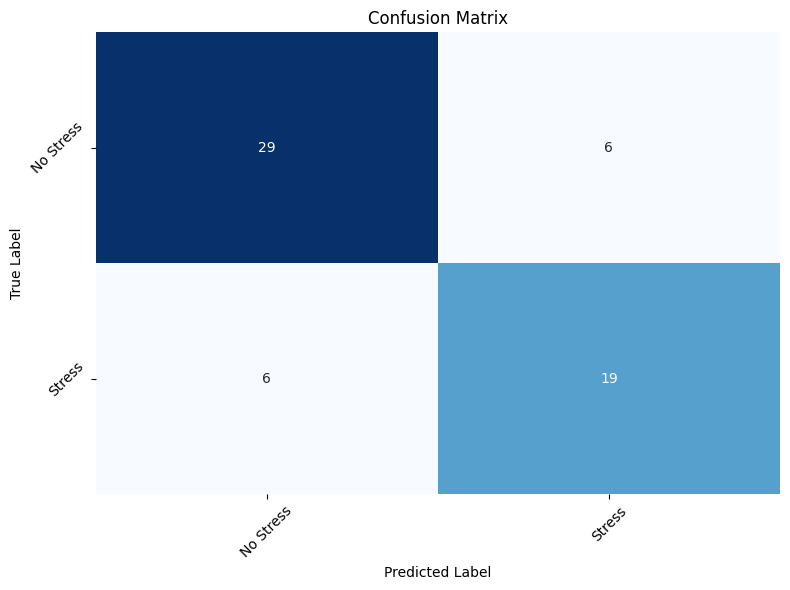

In [77]:
# Confusion Matrix Plot

y_true = comparison_df["stress_annotation"].tolist()
y_pred = comparison_df["bert_prediction"].tolist()

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["No Stress", "Stress"], columns=["No Stress", "Stress"])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


## Stress Test the Remaining Dataset

In [216]:
# Remove the annotated songs from the test set
billboard_df = pd.read_csv("billboard_database_with_spotify.csv")
annotated_df = pd.read_csv("manually_annotated_songs.csv")

# Get the IDs of songs that were manually annotated
annotated_ids = set(annotated_df["id"])

# Replace some missing IDs
billboard_df["id"] = billboard_df.index + 1

# Filter out the annotated songs from the dataset
df = billboard_df[~billboard_df["id"].isin(annotated_ids)]

df = df.dropna(subset=['lyrics'])

# Save the new DataFrame as a CSV file
df.to_csv("remaining_billboard_songs.csv", index=False)


In [211]:
# Chunk lyrics
df['text'] = df['lyrics'].apply(chunk_lyrics)

# Explode the 'text' column to create a new row for each chunk
chunked_df = df.explode('text', ignore_index=True)
chunked_df = chunked_df[["id", "text"]]

chunked_df = chunked_df.dropna(subset=['text'])

print(chunked_df.head())
print(f"\nNumber of Chunks: {len(chunked_df)}")

   id                                               text
0   1  There's a summer place\nWhere it may rain or s...
1   1  Yet I'm safe and warm\nFor within that summer ...
2   1  Your arms reach out to me\nAnd my heart is fre...
3   1  For it knows\nThere are no gloomy skies\nWhen ...
4   1  When seen through the eyes\nOf those who are b...

Number of Chunks: 140153


In [212]:
# Convert the pandas DataFrame to Dataset
dataset = Dataset.from_pandas(chunked_df)

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_chunked_df = dataset.map(tokenize_function, batched=True)

print(tokenized_chunked_df)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/140153 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 140153
})


In [217]:
# Get preds

bert_lyric_chunk_predictions = trainer.predict(tokenized_chunked_df).predictions.argmax(axis=1)

len(bert_lyric_chunk_predictions)

140153

In [218]:
chunked_df['bert_lyric_chunk_predictions'] = bert_lyric_chunk_predictions
chunked_df.head()

,id,text,bert_lyric_chunk_predictions
0,1,There's a summer place\nWhere it may rain or s...,0
1,1,Yet I'm safe and warm\nFor within that summer ...,0
2,1,Your arms reach out to me\nAnd my heart is fre...,0
3,1,For it knows\nThere are no gloomy skies\nWhen ...,0
4,1,When seen through the eyes\nOf those who are b...,0


In [220]:
# Get the lyric stress predictions
final_predictions = lyric_pred_from_chunks(chunked_df)

In [ ]:
# Put the predictions back in the DF
df['bert_prediction'] = ""

for key, value in final_predictions.items():
  df.loc[df['id'] == key, 'bert_prediction'] = int(value)

In [227]:
# Clear up DF
df = df[df['bert_prediction'].apply(lambda x: isinstance(x, (int, float)))]

In [228]:
# Save DF
df.to_csv("remaining_billboard_songs_with_predictions.csv", index=False)

## Visualise Results

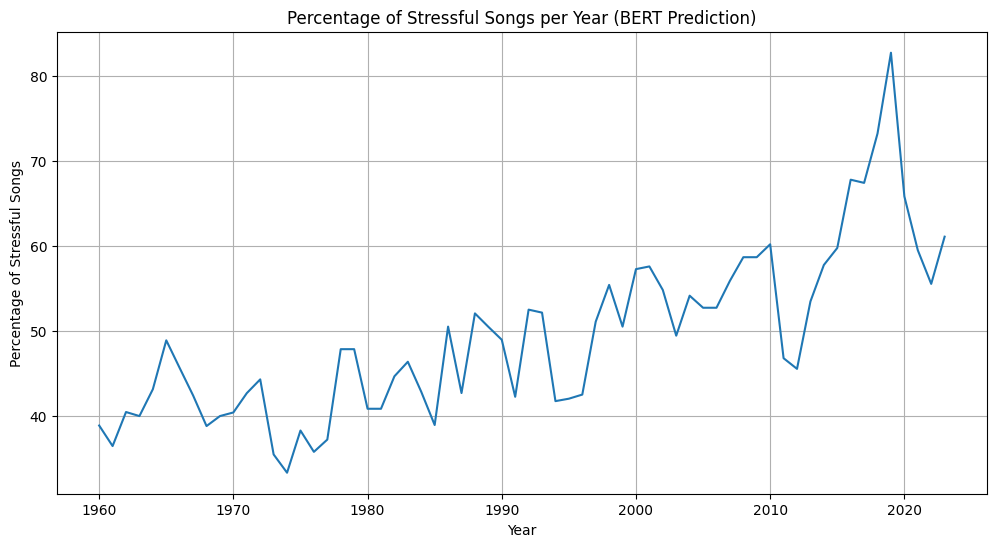

In [229]:
# Plot percentage of stressful songs per year
stress_percentage_per_year = df.groupby('Year')['bert_prediction'].mean() * 100

plt.figure(figsize=(12, 6))
plt.plot(stress_percentage_per_year.index, stress_percentage_per_year.values)
plt.xlabel('Year')
plt.ylabel('Percentage of Stressful Songs')
plt.title('Percentage of Stressful Songs per Year (BERT Prediction)')
plt.grid(True)
plt.show()


In [4]:
genre_stress_counts = {"Pop":0,
                       "Rock":0,
                       "Metal": 0,
                       "Country":0,
                       "Folk":0,
                       "Hip hop":0,
                       "Blues":0,
                       "Jazz":0}
genre_total_counts =  {"Pop":0,
                       "Rock":0,
                       "Metal": 0,
                       "Country":0,
                       "Folk":0,
                       "Hip hop":0,
                       "Blues":0,
                       "Jazz":0}

for index, row in df.iterrows():
  genre = str(row["Genres"])
  genre = genre.lower()

  if row["bert_prediction"] == 1:
    if "rock" in genre:
        genre_stress_counts["Rock"] += 1
    elif "pop" in genre:
        genre_stress_counts["Pop"] += 1
    elif "metal" in genre:
        genre_stress_counts["Metal"] += 1
    elif "country" in genre:
        genre_stress_counts["Country"] += 1
    elif "folk" in genre:
        genre_stress_counts["Folk"] += 1
    elif "hip" in genre:
        genre_stress_counts["Hip hop"] += 1
    elif "blues" in genre:
        genre_stress_counts["Blues"] += 1
    elif "jazz" in genre:
        genre_stress_counts["Jazz"] += 1

  if "rock" in genre:
        genre_total_counts["Rock"] += 1
  elif "pop" in genre:
      genre_total_counts["Pop"] += 1
  elif "metal" in genre:
      genre_total_counts["Metal"] += 1
  elif "country" in genre:
      genre_total_counts["Country"] += 1
  elif "folk" in genre:
      genre_total_counts["Folk"] += 1
  elif "hip" in genre:
      genre_total_counts["Hip hop"] += 1
  elif "blues" in genre:
      genre_total_counts["Blues"] += 1
  elif "jazz" in genre:
      genre_total_counts["Jazz"] += 1

# Calculate the percentage of stressed songs for each genre
genre_stress_percentages = {}

for genre, stress_count in genre_stress_counts.items():
    genre_stress_percentages[genre] = (stress_count / genre_total_counts[genre]) * 100


# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(genre_stress_percentages.keys(), genre_stress_percentages.values())
plt.xlabel("Genre")
plt.ylabel("Percentage of Stressed Songs")
plt.title("Percentage of Stressed Songs by Genre")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
